In [64]:
%alias_magic t timeit -p "-o -n 1 -r 1 -q"

Created `%t` as an alias for `%timeit -o -n 1 -r 1 -q`.
Created `%%t` as an alias for `%%timeit -o -n 1 -r 1 -q`.


In [41]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math

# MI-PRC - Path tracing report

_Jiří Šebele_

## Problem definition

Path tracing is a Monte Carlo computer graphics rendering method, which
produces scenes that are very faithful to reality. In theory, it's
integrating the surface radiance function over all directions for every
point in the scene. In practicality, it's simulating a ray of light
through the scene, collecting info about everything it hits on the way.
And it does it pseudorandomly, which is where the Monte Carlo part comes
from. Therefore, there are the following parameters to each scene:

 - Resolution in pixels
 - Samples per pixel
 - Amount of geometry in the scene
 
We'll try playing around with each of them and see where that takes us.

## Sequential implementation

TODO

## Adapting for the GPU

After implementing the sequential part of this assignment, it's time to parallelize it and run it on the GPU. The sequential implementation is already well suited to run in parallel. The only thing we have to change to get going is to replace two for-loops in the sequential implementation...

```c++
for (uint32_t x = 0; x < width; x++) {
    for (uint32_t y = 0; y < height; y++) {
        render_equation(...);
    }
}
```

...with a CUDA kernel...

```c++
__global__
void render_kernel(...) {
    uint64_t x = blockIdx.x * blockDim.x + threadIdx.x;
    uint64_t y = blockIdx.y * blockDim.y + threadIdx.y;

    render_equation(...);
}
```

...and an appropriate kernel call.

```c++
dim3 block(32, 32, 1);
dim3 grid(width / block.x, height / block.y, 1);

render_kernel<<<grid, block>>>(...);
```

We use a block of size 32 by 32 pixels, so we fill all of the 1024 threads in a block. Then we compute how many blocks we need to fit into the resolution and off we go.

Next up we'll try to curb the amount of global memory accesses by moving the scene into shared memory. We'll allocate enough space for the scene and use each thread to copy one sphere. That will help with memory coalescing and speed up subsequent intersection checks.

```c++
extern __shared__ Sphere shared_spheres[];

if (threadIdx.x < sphere_count) {
    shared_spheres[threadIdx.x] = device_spheres[threadIdx.x];
}
__syncthreads();
```

We also need to modify the kernel call to allocate enough shared memory.

```c++
render_kernel<<<grid, block, spheres.size() * sizeof(Sphere)>>>(...);
```

## Time measurements

Let's see how much the changes helped and do some time measurements of the performance.

### Sequential implementation

Let's see how the sequential implementation fares with minimal parameters (128 samples per pixel with a resolution of 512 by 512 pixels).

```console
$ time ./main_cpu -w 512 -h 512 -s 128 -o output.ppm
Rendering...
Rendering 511, 511
Saved image to 'output.ppm'
./main  509.50s user 6.17s system 99% cpu 8:35.91 total
```

As we can see, that's laughably slow, so we're not going to even bother pushing it further.

### GPU implementation

Let's see how the GPU version does with the same problem.

In [70]:
!nvprof ./main_gpu -w 512 -h 512 -s 128 -o output.ppm

==11842== NVPROF is profiling process 11842, command: ./main_gpu -w 512 -h 512 -s 128 -o output.ppm
Rendering...
Saved image to 'output.ppm'
==11842== Profiling application: ./main_gpu -w 512 -h 512 -s 128 -o output.ppm
==11842== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   98.74%  71.231ms         1  71.231ms  71.231ms  71.231ms  render_kernel(float3*, unsigned int, unsigned int, unsigned int, Sphere*, unsigned long)
                    1.26%  911.24us         1  911.24us  911.24us  911.24us  [CUDA memcpy DtoH]
                    0.00%     736ns         1     736ns     736ns     736ns  [CUDA memcpy HtoD]
      API calls:   71.64%  187.35ms         2  93.674ms  238.74us  187.11ms  cudaMalloc
                   28.04%  73.331ms         2  36.665ms  16.221us  73.315ms  cudaMemcpy
                    0.24%  633.59us         2  316.79us  244.69us  388.89us  cudaFree
                    0.04%  99.966us        97  1.0

That's a *lot* faster. Now let's see how far we can push it.

In [71]:
!nvprof ./main_gpu -w 3840 -h 2160 -s 8096 -o output.ppm

==11847== NVPROF is profiling process 11847, command: ./main_gpu -w 3840 -h 2160 -s 8096 -o output.ppm
Rendering...
Saved image to 'output.ppm'
==11847== Profiling application: ./main_gpu -w 3840 -h 2160 -s 8096 -o output.ppm
==11847== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   99.97%  138.346s         1  138.346s  138.346s  138.346s  render_kernel(float3*, unsigned int, unsigned int, unsigned int, Sphere*, unsigned long)
                    0.03%  43.683ms         1  43.683ms  43.683ms  43.683ms  [CUDA memcpy DtoH]
                    0.00%     800ns         1     800ns     800ns     800ns  [CUDA memcpy HtoD]
      API calls:   99.86%  138.391s         2  69.1953s  16.816us  138.391s  cudaMemcpy
                    0.14%  187.26ms         2  93.629ms  242.39us  187.01ms  cudaMalloc
                    0.00%  3.7191ms         2  1.8595ms  247.11us  3.4719ms  cudaFree
                    0.00%  100.62us        9

Just over two minutes. That's *still* 4 times faster than the sequential implementation. Let's look at the result now.

![output.ppm](render1.png)

Pretty good!

### Parameter sensitivity

Next up let's check how our algorithm reacts to changes in the parameters.

#### Resolution

Let's see how changing the resolution impacts the time.

In [60]:
resolutions = []
results = []
for size in range(256, 4096, 128):
    result = %t !./main_gpu -w {size} -h {size} -s 128 > /dev/null
    results.append(result)
    resolutions.append(size)

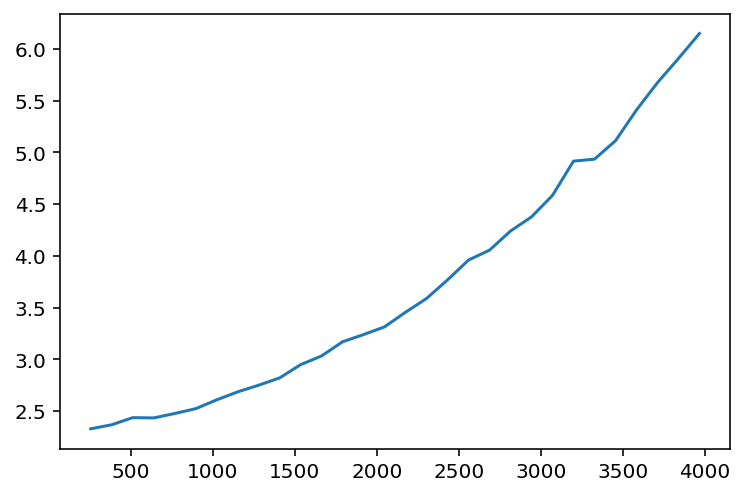

In [63]:
plt.plot(resolutions, list(map(lambda x: x.best, results)))
plt.show()

We can see a pretty predictable exponential increase in complexity, since each step increases the total area. Nothing new under the sun there.

#### Samples per pixel

Let's see how increasing the samples per pixel changes the complexity.

In [73]:
spps = []
results = []
for spp in range(128, 4096, 128):
    result = %t !./main_gpu -w 128 -h 128 -s {spp} > /dev/null
    results.append(result)
    spps.append(spp)

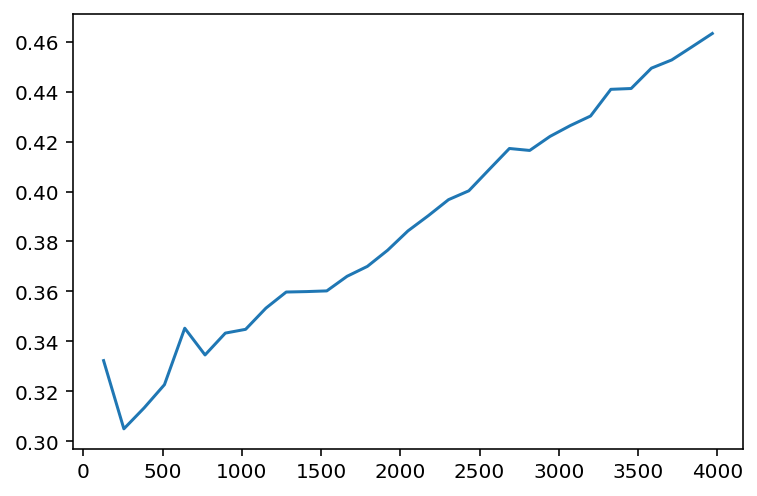

In [74]:
plt.plot(spps, list(map(lambda x: x.best, results)))
plt.show()

Here, the change is expectedly linear. Double the samples means double the work. So far so good.

#### Amount of geometry

Let's see how adding additional spheres to the scene changes the complexity.

In [79]:
counts = []
results = []
for count in range(0, 64):
    result = %t !./main_gpu -w 128 -h 128 -s 1024 -r {count} > /dev/null
    results.append(result)
    counts.append(count)

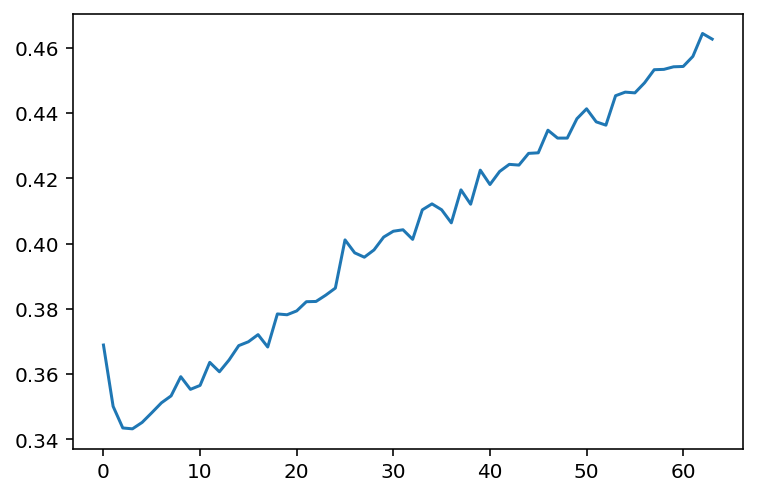

In [80]:
plt.plot(counts, list(map(lambda x: x.best, results)))
plt.show()

Here, the change also seems linear. Which makes sense, because for each pixel the number of intersection checks is $|spheres| * bounces$.

## Conclusion

Since our algorithm was designed to be parallelized from the ground up, it required very little change to adapt to GPU. Running it in parallel proved to be an order of magnitude faster. This made it feasible to render images with less noise and higher resolution. Further optimizations could be made to further improve performance (for example adding a BVH hierarchy), but for the sake of this assignment, I tried to keep it as simple as possible.